In [1]:
import sys
import os
# Detect if running in Google Colab
if "google.colab" in sys.modules:
    !pip install ultralytics

    # make utils dir
    os.makedirs("/content/src/utils", exist_ok=True)
    !wget -O /content/src/utils/utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/utils.py
    !wget -O /content/src/utils/preprocess_utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/preprocess_utils.py
    sys.path.append("/content/src")

    # make scripts dir
    os.makedirs("/content/src/scripts", exist_ok=True)
    !wget -O /content/src/scripts/inference.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/scripts/inference.py

    # import config from git
    !wget -O /content/config.yaml https://raw.githubusercontent.com/jayyang17/pool_management_system/main/config.yaml

    # get training data from s3
    os.makedirs("/content/artifact", exist_ok=True)
    !wget aws s3 cp 'https://poolmanagementsystem.s3.ap-southeast-1.amazonaws.com/raw_data/data.zip' -O /content/artifact/data.zip

    # get video sample from s3
    # !wget aws s3 cp 'https://poolmanagementsystem.s3.ap-southeast-1.amazonaws.com/raw_data/test_video.mp4' -O /content/video.mp4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Normal import (works in both local & Colab)
import ultralytics
from src.utils.utils import unzip_file, read_yaml, write_yaml, save_model, zip_model
from src.utils.preprocess_utils import process_dataset, augment_images, balance_dataset,create_yolo_data_yaml, split_train_val


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Import Configurations

In [3]:
# config
config = read_yaml('./config.yaml')

In [5]:
import yaml

# Label studio data
RAW_DATA_PATH = config["RAW_DATA_PATH"]

# PATH CONFIGURATIONS
ARTIFACT_DIR      = config["ARTIFACT_DIR"]
ORIGINAL_PATH     = config["ORIGINAL_PATH"]

# Original data paths (from Label Studio)
ORIGINAL_IMG_DIR  = config["ORIGINAL_IMG_DIR"]    # Images from Label Studio
YOLO_LABELS_DIR   = config["YOLO_LABELS_DIR"]     # YOLO labels from Label Studio

# Resized data paths (before augmentation)
RESIZED_IMG_DIR   = config["RESIZED_IMG_DIR"]     # Resized images
RESIZED_LABELS_DIR = config["RESIZED_LABELS_DIR"]    # Updated YOLO labels

# Augmented data paths
AUGMENTED_IMG_DIR   = config["AUGMENTED_IMG_DIR"]     # Augmented images
AUGMENTED_LABELS_DIR = config["AUGMENTED_LABELS_DIR"]   # Augmented YOLO labels

# Target training directories
TRAINING_IMG_DIR   = config["TRAINING_IMG_DIR"]
TRAINING_LABELS_DIR = config["TRAINING_LABELS_DIR"]

# Other paths
SOURCE_TRAIN_DIR  = config["SOURCE_TRAIN_DIR"]
MODEL_OUTPUT_DIR  = config["MODEL_OUTPUT_DIR"]
ZIP_MODEL_PATH    = config["ZIP_MODEL_PATH"]
CLASSES_TXT_PATH  = config["CLASSES_TXT_PATH"]
DATA_YAML_PATH    = config["MODEL"]["DATA_YAML_PATH"]

# data path for model training
# Determine the base path dynamically, to avoid changing the env
if os.path.exists('/content'):
    # Set the dataset path for Colab
    DATA_PATH = '/content/data'
else:
    # For local
    DATA_PATH = os.path.join(os.getcwd(), 'data')


MODEL_CONFIG = config["MODEL"]
TRAINING_CONFIG = config["TRAINING"]

# Model settings
pretrain_model = MODEL_CONFIG["PRETRAIN_MODEL"]
data_yaml = MODEL_CONFIG["DATA_YAML_PATH"]

# Training parameters
img_size = TRAINING_CONFIG["IMG_SIZE"]
epochs = TRAINING_CONFIG["NUM_EPOCHS"]
batch_size = TRAINING_CONFIG["BATCH_SIZE"]
lr0 = TRAINING_CONFIG["LR0"]
weight_decay = TRAINING_CONFIG["WEIGHT_DECAY"]
patience = TRAINING_CONFIG["PATIENCE"]

# Model output paths
model_output = config["MODEL_OUTPUT_DIR"]
runs_path = config["RUN_PATH"]
model_weights = config["MODEL_WEIGHTS"]

# Training parameters
TRAINING_CONFIG = config["TRAINING"]
NUM_EPOCHS = TRAINING_CONFIG["NUM_EPOCHS"]
IMG_SIZE   = TRAINING_CONFIG["IMG_SIZE"]





# Upload Dataset and prepare training data

In [6]:
# unzip the zip file generated from label-studio into the output dir
unzip_file(RAW_DATA_PATH,ORIGINAL_PATH)

Successfully extracted ./artifact/data.zip to ./artifact/original_data


# Preprocess

In [7]:
# resize the image
process_dataset(ORIGINAL_IMG_DIR, RESIZED_IMG_DIR, RESIZED_LABELS_DIR, YOLO_LABELS_DIR)

Processed pinterest-06_jpg.rf.ed9d22a5a547ac3517746ba0f949f2e4.jpg
Processed train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg
Processed pinterest-16_jpg.rf.fb0904b1ed64e4df94ae97dab3b0605e.jpg
Processed train-08_png.rf.ac63b89e846d3ee3e6fb6f5d91b79d5e.jpg
Processed pinterest-21_jpg.rf.605613c2d093bb9dd89a30519e712f8e.jpg
Processed pinterest-22_jpg.rf.d086147ad86164fc6df8d742454182de.jpg
Processed train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Processed train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Processed pinterest-20_jpg.rf.b7d8c3b7a93e0bce592c08e0f3aeeeeb.jpg
Processed pinterest-25_jpg.rf.a49077860ac4a05bfa1b52d7f327cb05.jpg
Processed train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Processed train-01_png.rf.a8e07fce39680e009f35050db3f6fe96.jpg
Processed pinterest-11_jpg.rf.98389ab55b22740e1bd60b98a7311ad4.jpg
Processed pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg
Processed pinterest-03_jpg.rf.204b632b4836e39b93cbd3e6e3c0b59a.jpg
Processed pinterest

In [8]:
augment_images(RESIZED_IMG_DIR, RESIZED_LABELS_DIR, AUGMENTED_IMG_DIR, AUGMENTED_LABELS_DIR)

Augmented: pinterest-06_jpg.rf.ed9d22a5a547ac3517746ba0f949f2e4.jpg --> aug_pinterest-06_jpg.rf.ed9d22a5a547ac3517746ba0f949f2e4.jpg
Augmented: train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg --> aug_train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg
Augmented: pinterest-16_jpg.rf.fb0904b1ed64e4df94ae97dab3b0605e.jpg --> aug_pinterest-16_jpg.rf.fb0904b1ed64e4df94ae97dab3b0605e.jpg
Augmented: train-08_png.rf.ac63b89e846d3ee3e6fb6f5d91b79d5e.jpg --> aug_train-08_png.rf.ac63b89e846d3ee3e6fb6f5d91b79d5e.jpg
Augmented: pinterest-21_jpg.rf.605613c2d093bb9dd89a30519e712f8e.jpg --> aug_pinterest-21_jpg.rf.605613c2d093bb9dd89a30519e712f8e.jpg
Augmented: pinterest-22_jpg.rf.d086147ad86164fc6df8d742454182de.jpg --> aug_pinterest-22_jpg.rf.d086147ad86164fc6df8d742454182de.jpg
Augmented: train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg --> aug_train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Augmented: train-07_png.rf.588b8660db71799422e9f255221198f9.jpg --> aug_train-07_png.rf.588b8

In [10]:
# Data splitting ratios
DATA_SPLIT = config["DATA_SPLIT"]
IMG_BALANCE_RATIO = DATA_SPLIT["img_balance_ratio"]

balance_dataset(
    RESIZED_IMG_DIR,
    RESIZED_LABELS_DIR,
    AUGMENTED_IMG_DIR,
    AUGMENTED_LABELS_DIR,
    TRAINING_IMG_DIR,
    TRAINING_LABELS_DIR,
    ratio_original=IMG_BALANCE_RATIO,
    total_samples=None)


Balanced dataset created with 34 original and 34 augmented images.


## split training and validation

In [11]:
# split training and validation images
TRAIN_RATIO       = DATA_SPLIT["train_ratio"]
split_train_val(TRAINING_IMG_DIR, TRAINING_LABELS_DIR, TRAIN_RATIO)

Found 68 images and 68 labels.
Splitting data: 54 for training, 14 for validation.
Data split complete! Check the 'train/' and 'validation/' folders.


In [12]:
# create the data.yaml file
create_yolo_data_yaml(DATA_PATH, CLASSES_TXT_PATH, DATA_YAML_PATH)

# check the data.yaml file
read_yaml(DATA_YAML_PATH)

YAML file created at ./data.yaml


{'path': '/content/data',
 'train': 'train/images',
 'val': 'validation/images',
 'nc': 2,
 'names': ['occupied', 'empty']}

# Model Training

In [13]:
from ultralytics import YOLO

# Define training parameters
PRETRAIN_MODEL = "yolov8n.pt"       # Pretrained model
DATA_YAML_PATH = "data.yaml"        # Path to data config
IMG_SIZE = 640                      # Standard YOLO input size
EPOCHS = 1                         # Reduce to prevent overfitting
BATCH_SIZE = 16                     # Increase if GPU allows
LR0 = 0.0005                        # Lower LR for more stable training
WEIGHT_DECAY = 0.0001               # Reduce overfitting risk
PATIENCE = 15                       # Keep early stopping but lower patience

# Load YOLO model
model = YOLO(PRETRAIN_MODEL)

# Start training with optimized settings
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LR0,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)

print("Training complete!")


100%|██████████| 6.25M/6.25M [00:00<00:00, 78.0MB/s]


Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=1, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/train/labels... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 648.91it/s]

train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/validation/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 1667.48it/s]

val: New cache created: /content/data/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.483      3.757      1.918        116        640: 100%|██████████| 4/4 [01:04<00:00, 16.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


                   all         14        229    0.00862      0.157    0.00887    0.00436

1 epochs completed in 0.023 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


                   all         14        229    0.00862      0.157    0.00762    0.00359
              occupied         10        114    0.00562      0.105    0.00517    0.00206
                 empty         11        115     0.0116      0.209     0.0101    0.00513
Speed: 2.5ms preprocess, 211.8ms inference, 0.0ms loss, 21.8ms postprocess per image
Results saved to runs/detect/train
Training complete!


## Save the best model

In [14]:
model_output = config["MODEL_OUTPUT_DIR"]
runs_path = config["RUN_PATH"]
model_weights = config["MODEL_WEIGHTS"]


In [15]:
print(model_output)
print(runs_path)
print(model_weights)

./final_model
./runs/detect
best.pt


In [16]:
# save model to colab
save_model(source_train_dir="/content/runs/detect/train",
               model_weights="best.pt",
               output_dir="/content/model")


Model files saved successfully at: /content/model
Model zipped successfully at: /content/model.zip


In [ ]:
zip_model_name = "/content/model.zip"

# zip model (optional)
zip_model(model_dir="/content/model", zip_path=zip_model_name)

# Image Predict


image 1/14 /content/data/validation/images/aug_pinterest-03_jpg.rf.204b632b4836e39b93cbd3e6e3c0b59a.jpg: 640x640 (no detections), 220.0ms
image 2/14 /content/data/validation/images/aug_pinterest-06_jpg.rf.ed9d22a5a547ac3517746ba0f949f2e4.jpg: 640x640 (no detections), 194.3ms
image 3/14 /content/data/validation/images/aug_pinterest-13_jpg.rf.a798bf9db710ea7611dfe815e58611e9.jpg: 640x640 (no detections), 192.0ms
image 4/14 /content/data/validation/images/aug_pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg: 640x640 (no detections), 197.8ms
image 5/14 /content/data/validation/images/aug_pinterest-22_jpg.rf.d086147ad86164fc6df8d742454182de.jpg: 640x640 (no detections), 203.3ms
image 6/14 /content/data/validation/images/aug_pinterest-23_jpg.rf.252e8093a2cd5f1d985131b992d00e79.jpg: 640x640 (no detections), 198.7ms
image 7/14 /content/data/validation/images/aug_train-07_png.rf.588b8660db71799422e9f255221198f9.jpg: 640x640 (no detections), 196.8ms
image 8/14 /content/data/validation/i

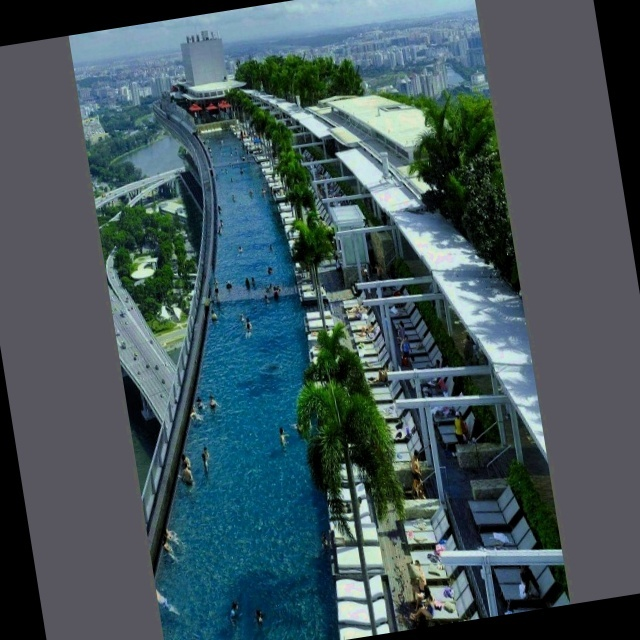

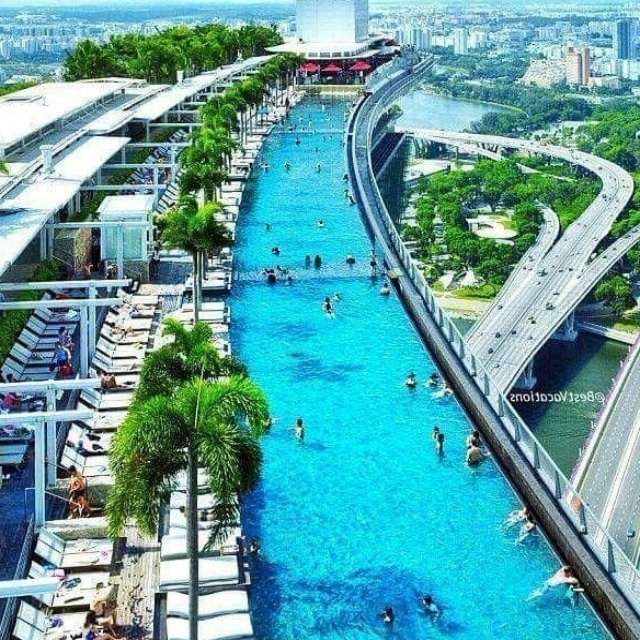

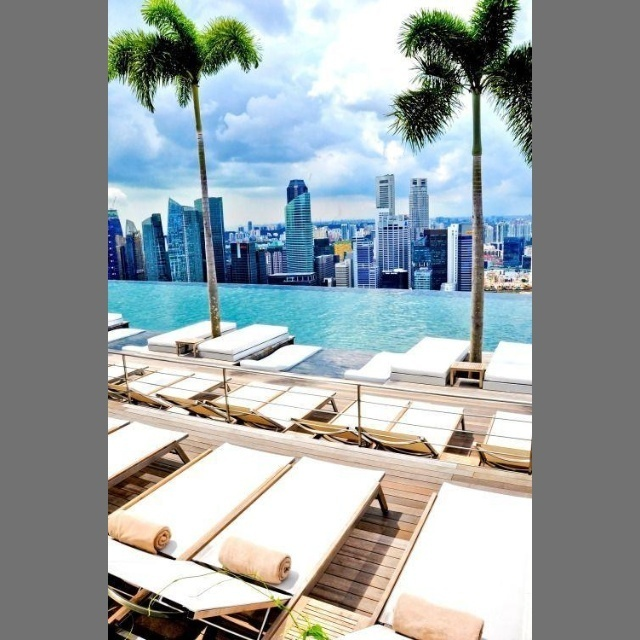

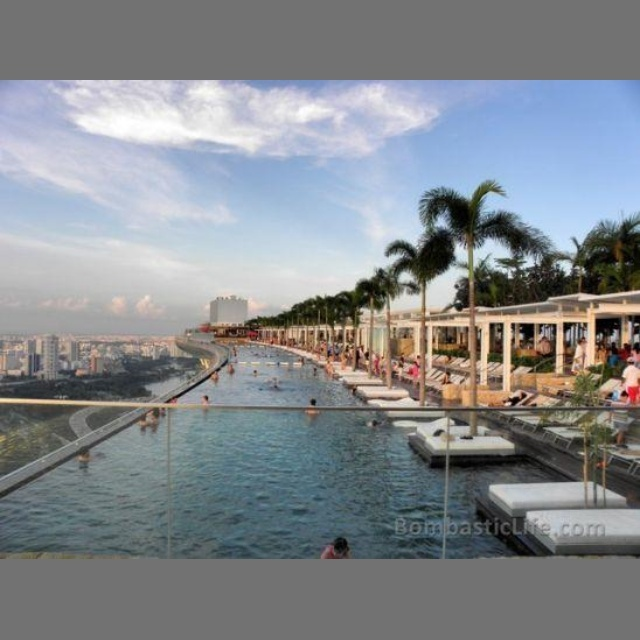

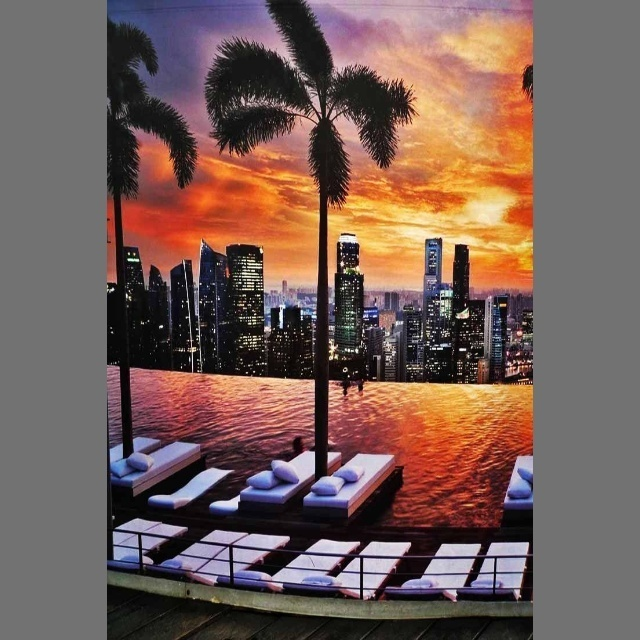

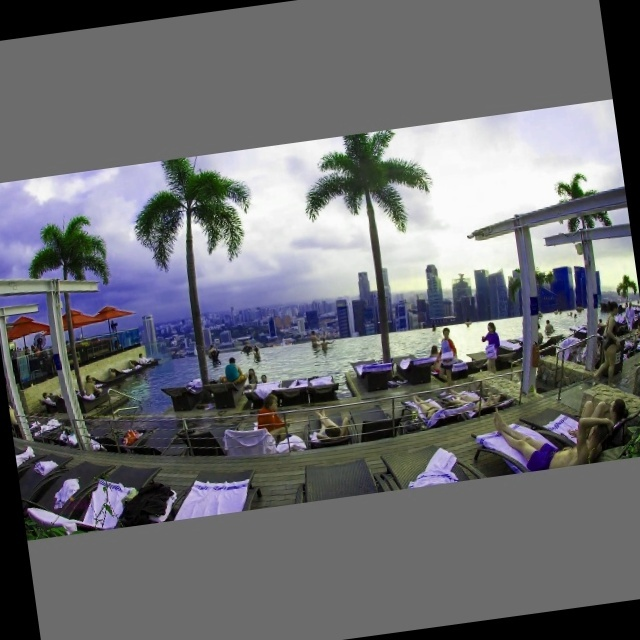

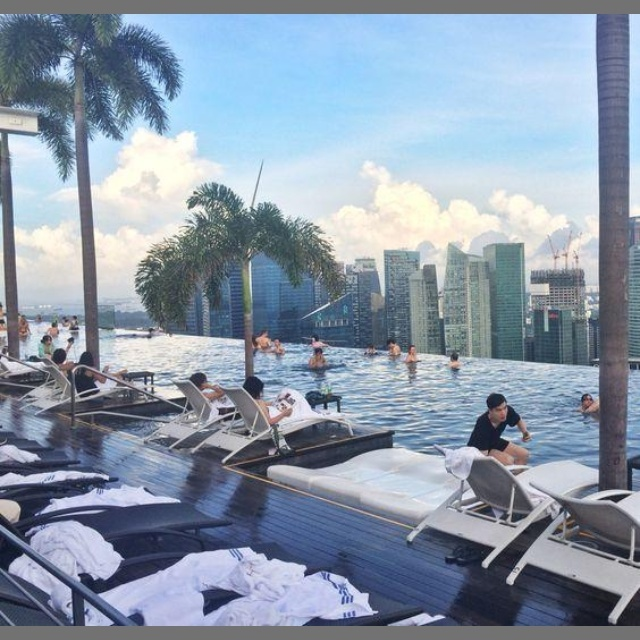

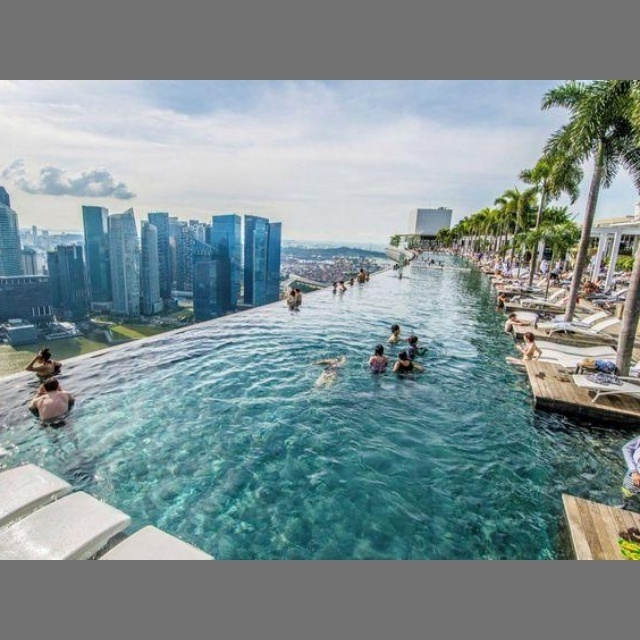

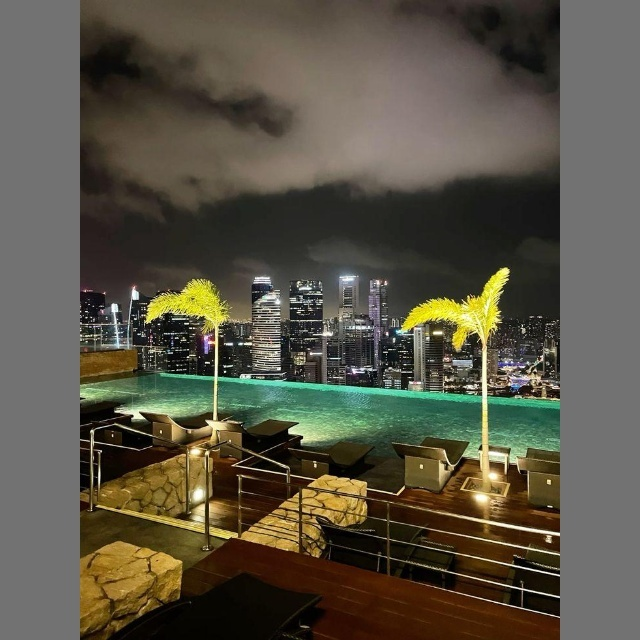

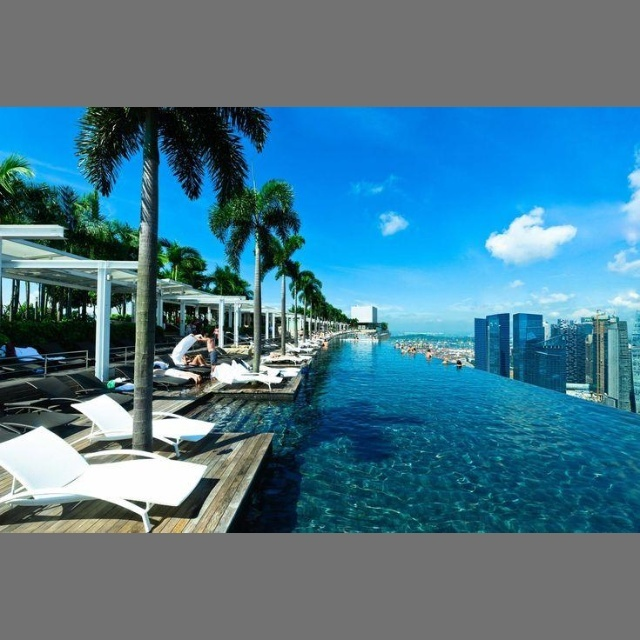

In [20]:
from ultralytics import YOLO
model_path = "/content/model/train/weights/best.pt"
# Load your trained YOLO model
# model = YOLO("/content/model/model.pt")  # Update the path if needed
model = YOLO(model_path)
test_image_path = "data/validation/images"

# Threshold CONFIGURATIONS
INFERENCE = config["INFERENCE"]
CONF_THRESHOLD = INFERENCE["CONF_THRESHOLD"]
IOU_THRESHOLD  = INFERENCE["IOU_THRESHOLD"]

# Run predict on images in a folder, use the variables from config if desired
results = model.predict(source=test_image_path, conf=0.5, iou=0.5, save=True)
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


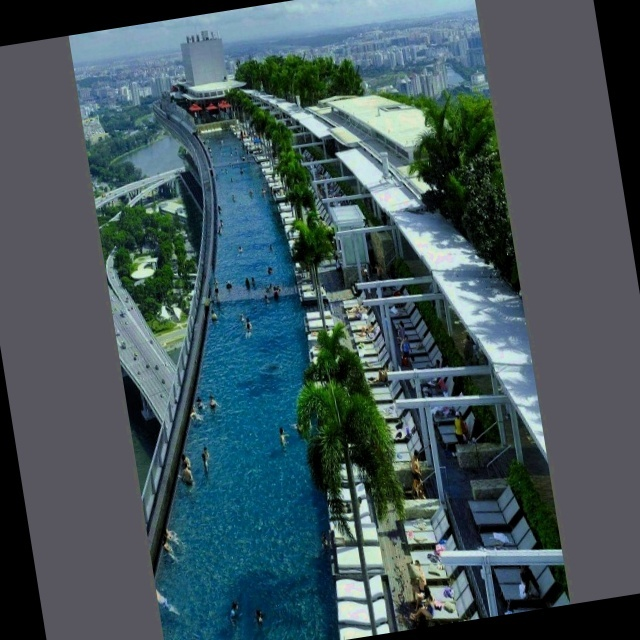

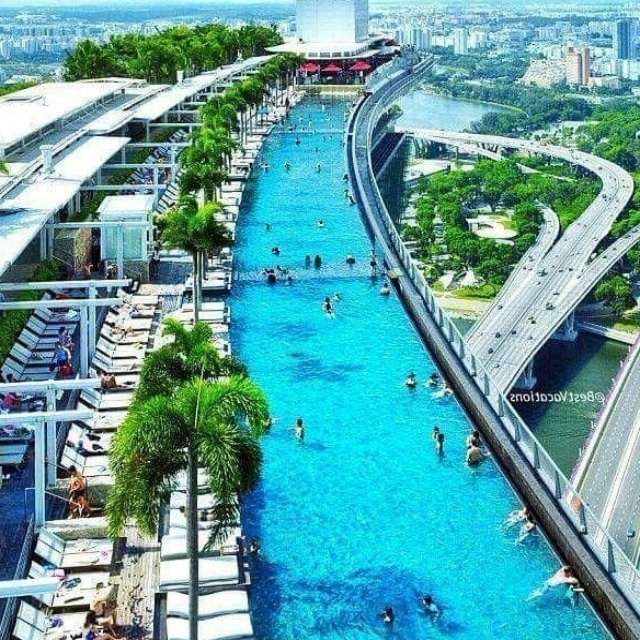

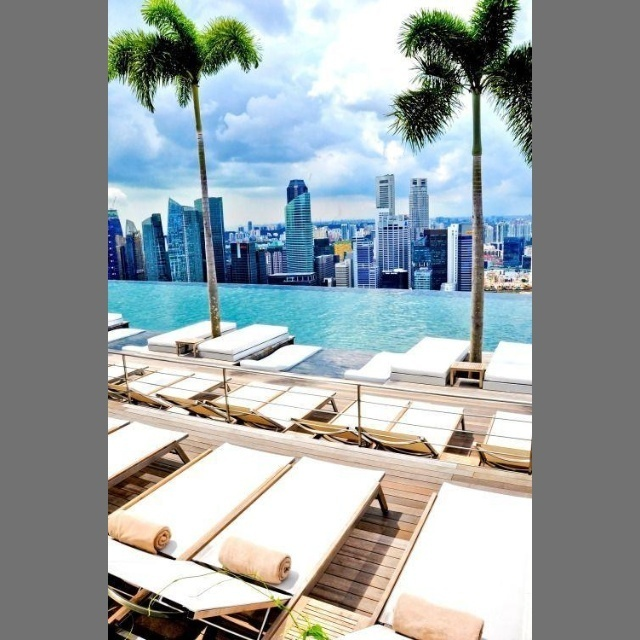

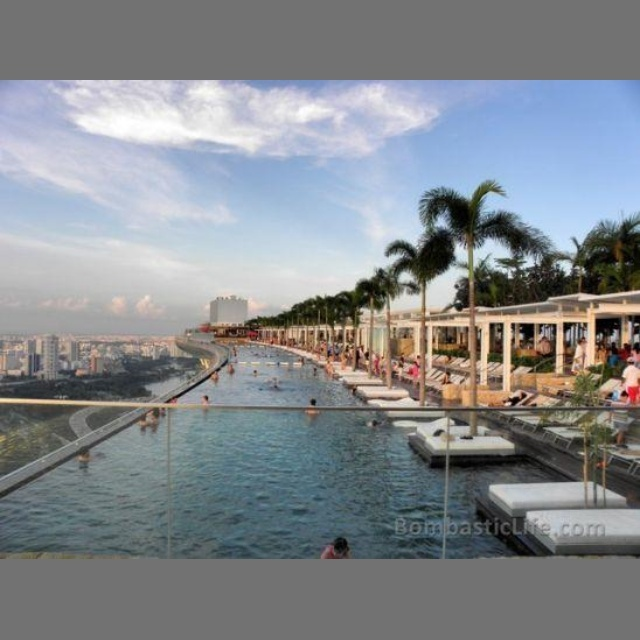

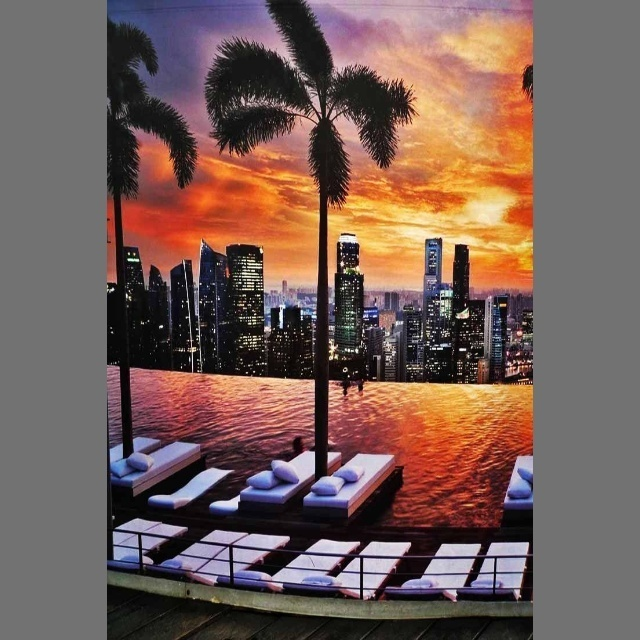

In [19]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:5]:
  display(Image(filename=image_path, height=400))
  print('\n')


# Video predict

In [ ]:
from src.scripts.inference import load_model, run_inference_on_video

video_path = "video_path"

run_inference_on_video(model, video_path, conf_threshold=CONF_THRESHOLD, imgsz=640)
